# Apache Sedona Tutorial - Spatial Join

This tutorial shows you how to create & analyse geospatial dataframes in Spark using Apache Sedona; as well as visualise the results

---

### Process
1. Initialise a Spark session with Sedona enabled
2. Load boundary & point datasets from parquet files
3. Convert them to geospatial dataframes
4. Perform a point in polygon spatial join
    - Fix the performance
5. Export the result to a Geopandas dataframe
6. Map the points, coloured by boundary type

---

### Import packages and set parameters

In [1]:
# fix autocomplete issue
%config Completer.use_jedi = False

In [2]:
# import Python packages

import os

from multiprocessing import cpu_count

from pyspark.sql import SparkSession
from pyspark.sql import functions as f

from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer

In [12]:
# set input path for parquet files
input_path = os.path.join(os.getcwd(), "data")
print(input_path)

# set max number of processes (defaults to number of physical CPUs)
num_processors = cpu_count()

/Users/s57405/git/iag_geo/spark_testing/apache_sedona/data


### Create the Spark session

In [13]:

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Sedona Tutorial") \
    .config("spark.serializer", KryoSerializer.getName) \
    .config("spark.kryo.registrator", SedonaKryoRegistrator.getName) \
    .config("spark.cores.max", num_processors) \
    .getOrCreate()

print("Spark {} session initialised".format(spark.version))

Spark 3.0.1 session initialised


Register Sedona's User Defined Types (UDTs) and Functions (UDFs) with the Spark session

In [14]:
SedonaRegistrator.registerAll(spark)

True

### Load dataframes

#### 1. Load boundary data from gzipped parquet files

Boundary geometries are polygons stored as OGC Well Known Text (WKT) strings.

In [15]:
bdy_wkt_df = spark.read.parquet(os.path.join(input_path, "boundaries"))
bdy_wkt_df.printSchema()
bdy_wkt_df.show(5)

print("Loaded {} records".format(bdy_wkt_df.count()))

root
 |-- bdy_id: string (nullable = true)
 |-- bdy_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- wkt_geom: string (nullable = true)

+------+--------------------+---------------+--------------------+
|bdy_id|            bdy_type|          state|            wkt_geom|
+------+--------------------+---------------+--------------------+
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.1082...|
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.1914...|
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.1914...|
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.1914...|
|  RA10|Major Cities of A...|New South Wales|POLYGON((149.2007...|
+------+--------------------+---------------+--------------------+
only showing top 5 rows

Loaded 17540 records


In [16]:
# add bdy number (last character of bdy ID) to bdy type - to enable display ordering in map
bdy_wkt_df2 = bdy_wkt_df \
    .withColumn("bdy_type", f.concat(f.substring(bdy_wkt_df["bdy_id"], -1, 1), f.lit(" - "), bdy_wkt_df["bdy_type"]))

# show 5 rows ordered randomly
bdy_wkt_df2.orderBy(f.rand()).show(5)

+------+--------------------+--------------------+--------------------+
|bdy_id|            bdy_type|               state|            wkt_geom|
+------+--------------------+--------------------+--------------------+
|  RA54|4 - Very Remote A...|   Western Australia|POLYGON((115.5303...|
|  RA63|3 - Remote Australia|            Tasmania|POLYGON((144.7363...|
|  RA81|1 - Inner Regiona...|Australian Capita...|POLYGON((148.9555...|
|  RA62|2 - Outer Regiona...|            Tasmania|POLYGON((147.9658...|
|  RA54|4 - Very Remote A...|   Western Australia|POLYGON((127.1278...|
+------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [17]:
# Create a view of the DataFrame to enable SQL queries
bdy_wkt_df2.createOrReplaceTempView("bdy_wkt")

#### 2. Load point data

Spatial data is stored in latitude & longitude (double precision) fields

In [18]:
point_wkt_df = spark.read.parquet(os.path.join(input_path, "points"))
point_wkt_df.printSchema()
point_wkt_df.show(5, False)

print("Loaded {} records".format(point_wkt_df.count()))

# create view to enable SQL queries
point_wkt_df.createOrReplaceTempView("point_wkt")

root
 |-- point_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

+-----------+---------------+-------------------+------------------+
|point_id   |state          |latitude           |longitude         |
+-----------+---------------+-------------------+------------------+
|10000023000|New South Wales|-36.05119023471413 |146.9322649496942 |
|10000061000|New South Wales|-36.077746939375054|146.94885126215476|
|10000080000|New South Wales|-36.051188172109605|146.9413308021523 |
|10000120000|New South Wales|-36.04635653576019 |146.92283341934643|
|10000152000|New South Wales|-36.04300542630207 |146.910526433595  |
+-----------+---------------+-------------------+------------------+
only showing top 5 rows

Loaded 89502 records


### Create geospatial dataframes

#### 1. Create boundary geometries from WKT strings

In [19]:
bdy_df = spark.sql("select bdy_id, bdy_type, state, st_geomFromWKT(wkt_geom) as geom from bdy_wkt")
#     .repartition(96, "state")
bdy_df.printSchema()
bdy_df.show(5)

print("{} partitions".format(bdy_df.rdd.getNumPartitions()))

# create view to enable SQL queries
bdy_df.createOrReplaceTempView("bdy")

root
 |-- bdy_id: string (nullable = true)
 |-- bdy_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = false)

+------+--------------------+---------------+--------------------+
|bdy_id|            bdy_type|          state|                geom|
+------+--------------------+---------------+--------------------+
|  RA10|0 - Major Cities ...|New South Wales|POLYGON ((149.108...|
|  RA10|0 - Major Cities ...|New South Wales|POLYGON ((149.191...|
|  RA10|0 - Major Cities ...|New South Wales|POLYGON ((149.191...|
|  RA10|0 - Major Cities ...|New South Wales|POLYGON ((149.191...|
|  RA10|0 - Major Cities ...|New South Wales|POLYGON ((149.200...|
+------+--------------------+---------------+--------------------+
only showing top 5 rows

6 partitions


#### 2. Create point geometries from lat/long fields

In [20]:
point_df = spark.sql("select point_id, state, st_point(longitude, latitude) as geom from point_wkt")
#     .repartition(96, "state")
point_df.printSchema()
point_df.show(5, False)

print("{} partitions".format(point_df.rdd.getNumPartitions()))

# create view to enable SQL queries
point_df.createOrReplaceTempView("pnt")

root
 |-- point_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = false)

+-----------+---------------+----------------------------------------------+
|point_id   |state          |geom                                          |
+-----------+---------------+----------------------------------------------+
|10000023000|New South Wales|POINT (146.9322649496942 -36.05119023471413)  |
|10000061000|New South Wales|POINT (146.94885126215476 -36.077746939375054)|
|10000080000|New South Wales|POINT (146.9413308021523 -36.051188172109605) |
|10000120000|New South Wales|POINT (146.92283341934643 -36.04635653576019) |
|10000152000|New South Wales|POINT (146.910526433595 -36.04300542630207)   |
+-----------+---------------+----------------------------------------------+
only showing top 5 rows

1 partitions


### Run a spatial join to boundary tag the points

##### Note:
1. One of the dataframes will be spatially indexed automatically to speed up the query
2. It's an inner join; point records could be lost in coastal areas or where there are gaps in the boundaries

In [21]:
from datetime import datetime

start_time = datetime.now()

sql = """SELECT pnt.point_id,
                bdy.bdy_id,
                bdy.bdy_type,
                bdy.state,
                pnt.geom
         FROM pnt
         INNER JOIN bdy ON ST_Intersects(pnt.geom, bdy.geom)"""
join_df = spark.sql(sql) \
    .cache()  # cache can save processing time when calling the same dataframe more than once
join_df.printSchema()
join_df.show(5, False)

join_count = join_df.count()

print("Boundary tagged {} points".format(join_count))
print("Query took {}".format(datetime.now() - start_time))

root
 |-- point_id: string (nullable = true)
 |-- bdy_id: string (nullable = true)
 |-- bdy_type: string (nullable = true)
 |-- state: string (nullable = true)
 |-- geom: geometry (nullable = false)

+-----------+------+----------------------------+---------------+----------------------------------------------+
|point_id   |bdy_id|bdy_type                    |state          |geom                                          |
+-----------+------+----------------------------+---------------+----------------------------------------------+
|10000023000|RA11  |1 - Inner Regional Australia|New South Wales|POINT (146.9322649496942 -36.05119023471413)  |
|10000061000|RA11  |1 - Inner Regional Australia|New South Wales|POINT (146.94885126215476 -36.077746939375054)|
|10000080000|RA11  |1 - Inner Regional Australia|New South Wales|POINT (146.9413308021523 -36.051188172109605) |
|10000120000|RA11  |1 - Inner Regional Australia|New South Wales|POINT (146.92283341934643 -36.04635653576019) |
|10000152

### Export result to Geopandas for visualisation

*note: doesn't scale to big data*

In [22]:
import geopandas

# convert to Pandas dataframe first (ordered for better visualisation)
pandas_df = join_df.orderBy(f.desc("bdy_type")).toPandas()

# convert to Geopandas dataframe
geopandas_df = geopandas.GeoDataFrame(pandas_df, geometry="geom")

geopandas_df

,point_id,bdy_id,bdy_type,state,geom
0,10135390000,RA14,4 - Very Remote Australia,New South Wales,POINT (144.74532 -30.27463)
1,10135700000,RA14,4 - Very Remote Australia,New South Wales,POINT (145.30879 -29.52486)
2,10136070000,RA14,4 - Very Remote Australia,New South Wales,POINT (144.61538 -29.17073)
3,10136370000,RA14,4 - Very Remote Australia,New South Wales,POINT (144.62503 -30.25149)
4,10137120000,RA14,4 - Very Remote Australia,New South Wales,POINT (144.49072 -29.85548)
...,...,...,...,...,...
89433,80056564800,RA80,0 - Major Cities of Australia,Australian Capital Territory,POINT (149.07187 -35.38201)
89434,80056565200,RA80,0 - Major Cities of Australia,Australian Capital Territory,POINT (149.16798 -35.22569)
89435,80056565600,RA80,0 - Major Cities of Australia,Australian Capital Territory,POINT (149.08577 -35.22902)
89436,80056566000,RA80,0 - Major Cities of Australia,Australian Capital Territory,POINT (149.04598 -35.32526)


### Map the result

<AxesSubplot:>

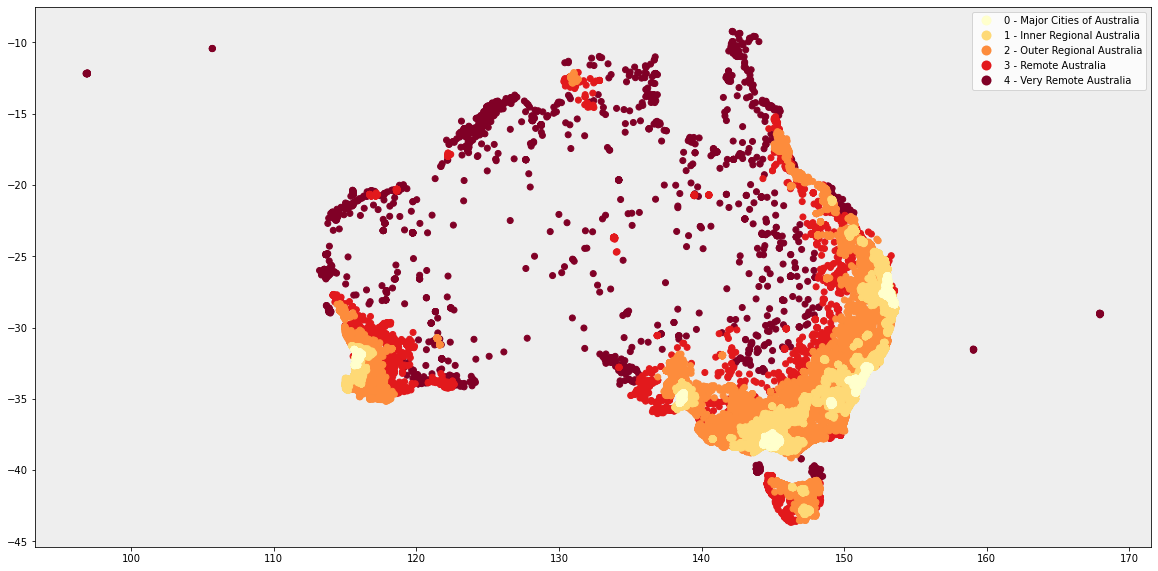

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(20, 20))

# et backgroun colour
ax.set_facecolor('#EEEEEE')

# create map of points by bdy type
geopandas_df.plot(
    column="bdy_type",
    legend=True,
    cmap='YlOrRd',
    ax=ax
)

<AxesSubplot:>

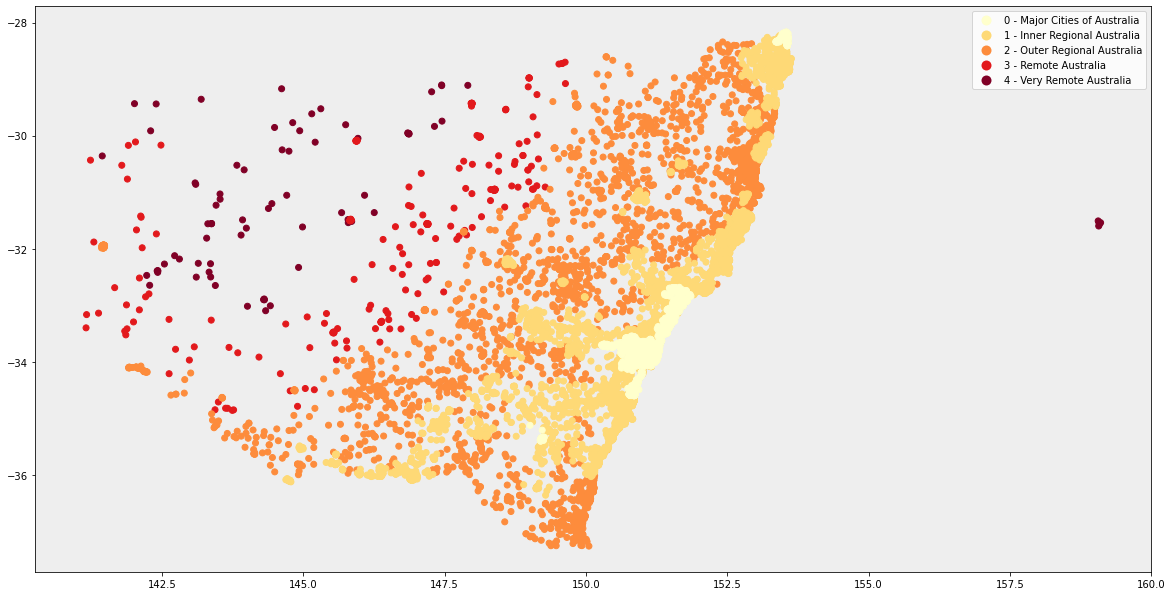

In [24]:
# map NSW only
fig2, ax2 = plt.subplots(1, figsize=(20, 20))
ax2.set_facecolor('#EEEEEE')

geopandas_df.loc[geopandas_df["state"] == "New South Wales"].plot(
    column="bdy_type",
    legend=True,
    cmap='YlOrRd',
    ax=ax2
)

### Close the Spark session

In [ ]:
spark.stop()